In [1]:
from torch.utils.data import DataLoader, Dataset
import torch
import torchvision.transforms as transforms
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import os
import cv2
import random
import matplotlib.pyplot as plt

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
transform = transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ])

class FrameInterpolationDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []

        for subdir in sorted(os.listdir(root_dir))[:500]:
            subdir_path = os.path.join(root_dir, subdir)

            frame_path1 = os.path.join(subdir_path, "frame1.jpg")
            frame_path2 = os.path.join(subdir_path, "frame2.jpg")
            frame_path3 = os.path.join(subdir_path, "frame3.jpg")

            frame1 = cv2.cvtColor(cv2.imread(frame_path1), cv2.COLOR_BGR2RGB)
            frame2 = cv2.cvtColor(cv2.imread(frame_path2), cv2.COLOR_BGR2RGB)
            frame3 = cv2.cvtColor(cv2.imread(frame_path3), cv2.COLOR_BGR2RGB)

            self.samples.append((frame1, frame2, frame3))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        frame1, frame2, frame3 = self.samples[idx]

        if self.transform:
            frame1 = self.transform(frame1)
            frame2 = self.transform(frame2)
            frame3 = self.transform(frame3)

        x = (frame1, frame3)
        y = frame2
        return x, y

In [4]:
images_train = FrameInterpolationDataset("./atd_12k/datasets/train_128px", transform=transform)

In [5]:
trainloader = DataLoader(images_train, batch_size=2, shuffle=True, num_workers=4)

In [6]:
def denormalize(img: torch.Tensor) -> np.ndarray:
    denorm = transforms.Normalize(mean=(-1, -1, -1), std=(2, 2, 2))
    img = denorm(img).permute(1, 2, 0).cpu().numpy()
    # img = (img * 255).astype(np.uint8)
    return img

def show(img, denorm=False):
    img = img.cpu()
    if denorm:
        img = denormalize(img)
        
    plt.imshow(img)
    plt.axis('off')
    plt.show()

def show_3_frames(x, y):
    _, axes = plt.subplots(1, 3, figsize=(10, 3))

    img = denormalize(x[0])
    img = (img * 255).astype(np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[0].imshow(img)

    img = denormalize(y)
    img = (img * 255).astype(np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[1].imshow(img)

    img = denormalize(x[1])
    img = (img * 255).astype(np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[2].imshow(img)

    plt.show()

In [7]:
x, y = random.choice(images_train)

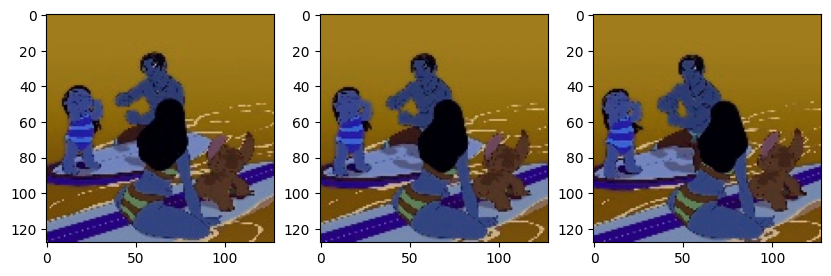

In [8]:
show_3_frames(x, y)

Wykorzystany memflow do generowania optical flow


github.com/DQiaole/MemFlow

In [9]:
from my_evaluate import generates_flow

please consider installing flash attention for faster inference


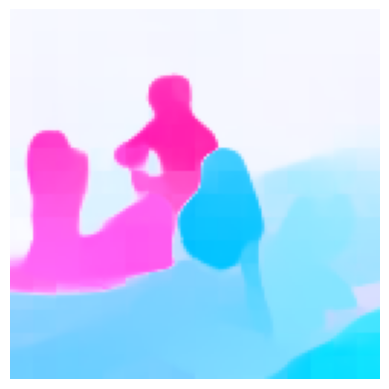

In [11]:
a = generates_flow(x[1], x[0])

show(torch.from_numpy(a).detach())

In [45]:
def warp(img, flow):
    B, _, H, W = img.size()
    grid_y, grid_x = torch.meshgrid(torch.arange(H), torch.arange(W), indexing='ij')
    grid = torch.stack((grid_x, grid_y), 2).float().to(img.device)  # H x W x 2
    grid = grid.unsqueeze(0).repeat(B, 1, 1, 1)  # B x H x W x 2
    flow = flow.permute(0, 2, 3, 1)
    new_grid = grid + flow
    new_grid[..., 0] = 2.0 * new_grid[..., 0] / (W - 1) - 1.0
    new_grid[..., 1] = 2.0 * new_grid[..., 1] / (H - 1) - 1.0
    return F.grid_sample(img, new_grid, align_corners=True)


def warp_with_fallback(img, flow):
    warped = warp(img, flow)
    # Maska: 1 tam gdzie grid_sample dał ≠ 0, 0 tam gdzie 0
    mask = (warped.abs().sum(1, keepdim=True) > 0).float()  # B x 1 x H x W
    # Uzupełnij oryginałem tam gdzie maska = 0
    output = warped * mask + img * (1 - mask)
    return output


class SynthesisNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(6, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size=3, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        return self.net(x)


class AnimeInterp(nn.Module):
    def __init__(self):
        super().__init__()
        self.synth_net = SynthesisNet()

    def forward(self, I0, I1, t=0.5):
        flows_f0_1 = []
        flows_f1_0 = []
        with torch.no_grad():
            for i in range(I0.size(0)):
                i0 = I0.cpu()
                i1 = I1.cpu()
                flow_01 = generates_flow(i0[i], i1[i])[:, :, :2]
                flow_10 = generates_flow(i1[i], i0[i])[:, :, :2]
                flows_f0_1.append(torch.from_numpy(flow_01).detach())
                flows_f1_0.append(torch.from_numpy(flow_10).detach())
        
        f0_1 = torch.stack(flows_f0_1).permute(0, 3, 1, 2).to(device)
        f1_0 = torch.stack(flows_f1_0).permute(0, 3, 1, 2).to(device)

        # Przesunięcia do t
        flow_t0 = -t * f0_1
        flow_t1 = (1 - t) * f1_0

        # Warpowanie
        I0_warp = warp_with_fallback(I0, flow_t0)
        I1_warp = warp_with_fallback(I1, flow_t1)

        # Synteza końcowego obrazu
        x = torch.cat([I0_warp, I1_warp], dim=1)
        It_pred = self.synth_net(x)

        return It_pred

In [ ]:
# class InterpolationAutoencoder(nn.Module):
#     def __init__(self):
#         super(InterpolationAutoencoder, self).__init__()
#         self.encoder = nn.Sequential(
#             nn.Conv2d(6, 64, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.Conv2d(64, 128, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.Conv2d(128, 256, kernel_size=3, padding=1),
#             nn.ReLU(),
#         )
#         self.decoder = nn.Sequential(
#             nn.Conv2d(256, 128, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.Conv2d(128, 64, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.Conv2d(64, 3, kernel_size=3, padding=1),
#             nn.Tanh(),
#         )

#     def forward(self, frame1, frame3, t=None):
#         x = torch.cat([frame1, frame3], dim=1)
#         x = self.encoder(x)
#         x = self.decoder(x)
#         return x

In [46]:
def psnr(pred, target, max_val=1.0):
    mse = F.mse_loss(pred, target)
    psnr = 10 * torch.log10(max_val ** 2 / mse)
    return psnr

In [ ]:
import torch.optim as optim

model = AnimeInterp().to(device)  # Działa już
# model = InterpolationAutoencoder().to(device)  # Losowy autoencoder działa
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.L1Loss()

In [54]:
epochs = 10

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for x, y in tqdm(trainloader):
        frame0, frame1 = x[0].to(device), x[1].to(device)
        frame_gt = y.to(device)

        pred = model(frame0, frame1, t=0.5)

        loss = criterion(pred, frame_gt)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"[{epoch+1}/{epochs}] Loss: {running_loss/len(trainloader):.6f}")


100%|██████████| 250/250 [02:43<00:00,  1.53it/s]


[1/10] Loss: 0.098944


100%|██████████| 250/250 [02:39<00:00,  1.56it/s]


[2/10] Loss: 0.094314


100%|██████████| 250/250 [02:41<00:00,  1.55it/s]


[3/10] Loss: 0.094280


100%|██████████| 250/250 [02:42<00:00,  1.53it/s]


[4/10] Loss: 0.091085


100%|██████████| 250/250 [02:39<00:00,  1.57it/s]


[5/10] Loss: 0.094165


100%|██████████| 250/250 [02:42<00:00,  1.54it/s]


[6/10] Loss: 0.088222


100%|██████████| 250/250 [02:42<00:00,  1.54it/s]


[7/10] Loss: 0.085834


100%|██████████| 250/250 [02:40<00:00,  1.56it/s]


[8/10] Loss: 0.084914


100%|██████████| 250/250 [02:43<00:00,  1.53it/s]


[9/10] Loss: 0.087629


100%|██████████| 250/250 [02:41<00:00,  1.55it/s]

[10/10] Loss: 0.086859


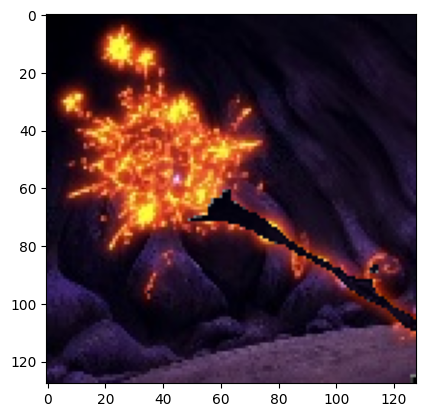

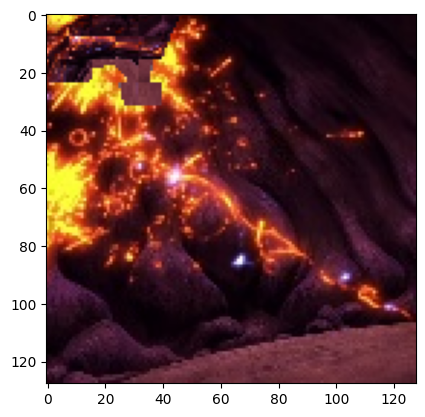

In [44]:
t = 0.5

(I0, I1), y = images_train[0]

flows_f0_1 = []
flows_f1_0 = []
with torch.no_grad():
    i0 = I0.cpu()
    i1 = I1.cpu()
    flow_01 = generates_flow(i0, i1)[:, :, :2]
    flow_10 = generates_flow(i1, i0)[:, :, :2]
    flows_f0_1.append(torch.from_numpy(flow_01).detach())
    flows_f1_0.append(torch.from_numpy(flow_10).detach())

f0_1 = torch.stack(flows_f0_1).permute(0, 3, 1, 2)
f1_0 = torch.stack(flows_f1_0).permute(0, 3, 1, 2)

# Przesunięcia do t
flow_t0 = -t * f0_1
flow_t1 = (1 - t) * f1_0

# Warpowanie
I0_warp = warp_with_fallback(I0.unsqueeze(0), flow_t0)
I1_warp = warp_with_fallback(I1.unsqueeze(0), flow_t1)

o0 = I0_warp.squeeze()
o1 = I1_warp.squeeze()
o0 = denormalize(o0)
o1 = denormalize(o1)
plt.imshow(o0)
plt.show()
plt.imshow(o1)
plt.show()

# Synteza końcowego obrazu
# x = torch.cat([I0_warp, I1_warp], dim=1)
# It_pred = self.synth_net(x)

In [ ]:
# torch.save(model, "lab5.pth")

In [76]:
def evaluate_on_two_images(model, img1, img2, device="cpu"):
    model.eval()
    with torch.no_grad():
        I0 = torch.Tensor(img1).unsqueeze(0)
        I1 = torch.Tensor(img2).unsqueeze(0)

        pred_mid = model(I0.to(device), I1.to(device))

        return pred_mid.squeeze(0)

In [89]:
x, y = random.choice(images_train)

img_tensor = evaluate_on_two_images(model, x[0], x[1], device=device)


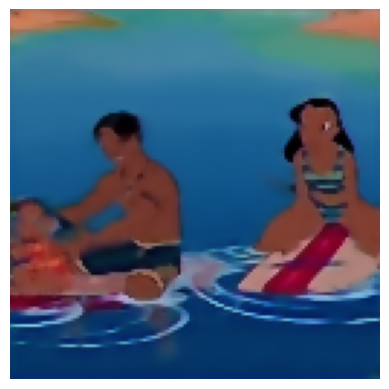

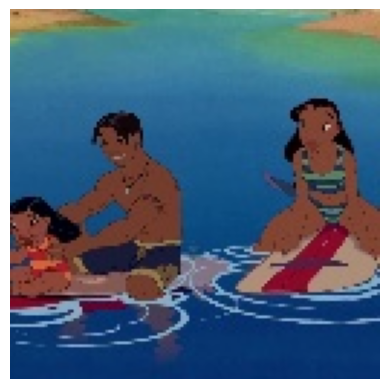

In [90]:
show(img_tensor, True)
show(y.squeeze(), True)

## PSNR

In [65]:
psnrs = []

model.eval()
for x, y in images_train:
    img_tensor = evaluate_on_two_images(model, x[0], x[1], device=device).cpu()
    psnrs.append(psnr(img_tensor, y))

psnrs = np.array(psnrs)

print(np.mean(psnrs), np.std(psnrs))


16.57014 3.0974257
